<a href="https://colab.research.google.com/github/CeciSC/LSTMEquityIndexPrediction/blob/main/csi300_RNN_monthly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add S&P 500 and HS300

In [1]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)


2.3.0


In [2]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import time

In [4]:
from google.colab import files
uploaded = files.upload()

Saving hs300_m.csv to hs300_m.csv


# New Section

In [5]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded['hs300_m.csv'].decode('utf-8')))
df

,Date,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,2005-05-31,855.95,856.5610,863.1980,853.2910,704782100,932.39,978.145,1035.934,945.08240,1000.38190,1104.238800,-9.431601,-14.438076,-79.787318,967.829815,831.480339,21.223350,27.985991,-3.560053,17.064143,-7.3950,-31.5970,95.616574,93.631458,-4.706346,-3.552373,24.553725,32.398227,58.333333,-6.128407e+08,-0.081983,-0.000713,0.268396,-0.029583,-0.012131,-0.154515,-0.224851
1,2005-06-30,878.69,897.1020,897.1020,876.8840,1085547200,855.95,932.390,978.145,929.84380,982.65350,1092.592250,-5.501763,-10.580281,-84.534682,933.626486,818.431053,50.384198,21.223350,-0.549043,17.094786,-21.9600,-4.8510,79.750617,71.830639,2.468696,1.925176,30.043510,34.753117,58.333333,-3.002550e+08,0.026567,-0.020524,0.089326,-0.016124,-0.010547,-0.157932,-0.195775
2,2005-07-29,888.16,889.4100,892.2940,883.3830,1339740600,878.69,855.950,932.390,899.47880,960.53750,1079.851700,-1.257928,-7.534688,-86.534687,913.053845,810.914078,83.963521,50.384198,4.955266,15.166286,44.1770,41.9330,75.201385,67.438507,1.788617,-0.309269,32.500076,35.770448,58.333333,-5.917872e+07,0.010777,-0.001405,0.536079,-0.032656,-0.011661,-0.176748,-0.177517
3,2005-08-31,927.92,915.1220,928.2120,911.5050,1462363000,888.16,878.690,855.950,896.62140,948.29920,1066.510300,3.490280,-2.149448,-83.944394,960.929517,885.192714,39.895282,83.963521,-2.785327,17.393786,4.5020,-26.5860,58.078913,40.218262,0.195115,0.621983,42.637982,40.047464,50.000000,3.867425e+08,0.044767,0.013985,0.982522,-0.003177,-0.012355,-0.169681,-0.129947
4,2005-09-30,917.39,916.5870,918.6620,913.4520,900143300,927.92,888.160,878.690,893.62080,933.75700,1048.313200,2.660099,-1.752597,-81.797852,982.043498,896.766425,17.248478,39.895282,-5.442319,12.082000,-5.8820,-52.8010,56.585733,33.248479,-2.930836,-0.526946,40.696194,39.291817,41.666667,3.864520e+07,-0.011348,0.000876,0.755854,-0.003347,-0.017062,-0.162108,-0.124889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2020-07-31,4695.05,4652.1824,4741.8084,4621.9635,18483902600,4163.96,3867.020,3912.580,4064.95308,4008.07201,3832.638965,15.500625,17.139767,161.842004,5007.630416,4149.894838,54.007821,90.082560,-1.041687,123.959114,-17.3895,-49.4225,13.312411,13.312411,0.578765,0.984893,79.717452,70.411355,75.000000,7.796604e+10,0.127544,0.009215,0.609842,0.038580,0.020263,0.082106,0.225018
183,2020-08-31,4816.22,4870.9337,4901.2115,4816.2123,20256702900,4695.05,4163.960,3867.020,4290.96512,4101.01835,3922.917050,12.240840,17.439496,213.900602,4865.399798,4572.975455,65.225476,54.007821,3.893742,79.199571,97.3722,180.5027,6.079734,6.805713,1.050575,0.800166,81.704544,72.099483,58.333333,8.184670e+10,0.025808,-0.011233,0.000091,0.055600,0.023555,0.119585,0.227714
184,2020-09-30,4587.40,4607.5753,4634.7239,4563.4108,8908120000,4816.22,4695.050,4163.960,4425.92874,4176.89082,3992.205160,3.648196,9.827992,233.996192,4864.012344,4502.855841,19.150296,65.225476,-1.368624,61.911900,-48.3655,-63.6554,22.447111,28.502008,-2.011459,-1.100676,66.860608,64.516476,50.000000,7.917849e+10,-0.047510,-0.004379,0.336393,0.031453,0.017662,0.128224,0.149089
185,2020-10-30,4695.33,4776.4726,4778.5089,4683.4719,13980230300,4587.40,4816.220,4695.050,4591.59086,4236.76599,4043.503335,2.259412,10.823534,255.684455,4876.068763,4540.763567,42.782870,19.150296,-2.325066,67.508279,-82.6507,-111.7683,14.726326,20.598374,0.226144,0.918400,69.950890,66.338340,41.666667,8.100637e+10,0.023527,-0.016988,0.124774,0.037430,0.012850,0.150139,0.161203


In [6]:
df.dtypes

Date                              object
Close                            float64
Open                             float64
High                             float64
Low                              float64
Volume                             int64
x(t-1)                           float64
x(t-2)                           float64
x(t-3)                           float64
MA5                              float64
MA10                             float64
MA20                             float64
BIAS5                            float64
BIAS10                           float64
DIFF                             float64
BU                               float64
BL                               float64
KDJ                              float64
KDJ(t-1)                         float64
ROC                              float64
TR（14）                           float64
MTM6                             float64
MTM12                            float64
WR%10                            float64
WR%5            

In [7]:
df[['Volume']] = df[['Volume']].astype('float')

df_feature = df
df_feature = df_feature.drop(['Date'], axis=1)
df_feature.head()

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,855.95,856.561,863.198,853.291,7.047821e+08,932.39,978.145,1035.934,945.0824,1000.3819,1104.23880,-9.431601,-14.438076,-79.787318,967.829815,831.480339,21.223350,27.985991,-3.560053,17.064143,-7.395,-31.597,95.616574,93.631458,-4.706346,-3.552373,24.553725,32.398227,58.333333,-6.128407e+08,-0.081983,-0.000713,0.268396,-0.029583,-0.012131,-0.154515,-0.224851
1,878.69,897.102,897.102,876.884,1.085547e+09,855.95,932.390,978.145,929.8438,982.6535,1092.59225,-5.501763,-10.580281,-84.534682,933.626486,818.431053,50.384198,21.223350,-0.549043,17.094786,-21.960,-4.851,79.750617,71.830639,2.468696,1.925176,30.043510,34.753117,58.333333,-3.002550e+08,0.026567,-0.020524,0.089326,-0.016124,-0.010547,-0.157932,-0.195775
2,888.16,889.410,892.294,883.383,1.339741e+09,878.69,855.950,932.390,899.4788,960.5375,1079.85170,-1.257928,-7.534688,-86.534687,913.053845,810.914078,83.963521,50.384198,4.955266,15.166286,44.177,41.933,75.201385,67.438507,1.788617,-0.309269,32.500076,35.770448,58.333333,-5.917872e+07,0.010777,-0.001405,0.536079,-0.032656,-0.011661,-0.176748,-0.177517
3,927.92,915.122,928.212,911.505,1.462363e+09,888.16,878.690,855.950,896.6214,948.2992,1066.51030,3.490280,-2.149448,-83.944394,960.929517,885.192714,39.895282,83.963521,-2.785327,17.393786,4.502,-26.586,58.078913,40.218262,0.195115,0.621983,42.637982,40.047464,50.000000,3.867425e+08,0.044767,0.013985,0.982522,-0.003177,-0.012355,-0.169681,-0.129947
4,917.39,916.587,918.662,913.452,9.001433e+08,927.92,888.160,878.690,893.6208,933.7570,1048.31320,2.660099,-1.752597,-81.797852,982.043498,896.766425,17.248478,39.895282,-5.442319,12.082000,-5.882,-52.801,56.585733,33.248479,-2.930836,-0.526946,40.696194,39.291817,41.666667,3.864520e+07,-0.011348,0.000876,0.755854,-0.003347,-0.017062,-0.162108,-0.124889


In [8]:
df_feature.shape

(187, 37)

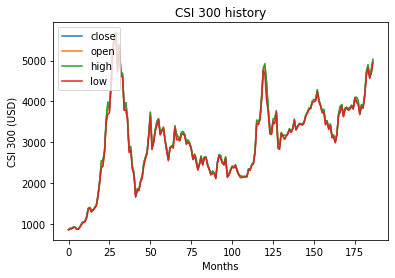

In [9]:
### EDA
plt.figure()
plt.plot(df_feature[["Close"]])
plt.plot(df_feature[["Open"]])
plt.plot(df_feature[["High"]])
plt.plot(df_feature[["Low"]])
plt.title('CSI 300 history')
plt.ylabel('CSI 300 (USD)')
plt.xlabel('Months')
plt.legend(['close', 'open','high','low'], loc='upper left')
plt.show()

In [10]:
df_feature

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,855.95,856.5610,863.1980,853.2910,7.047821e+08,932.39,978.145,1035.934,945.08240,1000.38190,1104.238800,-9.431601,-14.438076,-79.787318,967.829815,831.480339,21.223350,27.985991,-3.560053,17.064143,-7.3950,-31.5970,95.616574,93.631458,-4.706346,-3.552373,24.553725,32.398227,58.333333,-6.128407e+08,-0.081983,-0.000713,0.268396,-0.029583,-0.012131,-0.154515,-0.224851
1,878.69,897.1020,897.1020,876.8840,1.085547e+09,855.95,932.390,978.145,929.84380,982.65350,1092.592250,-5.501763,-10.580281,-84.534682,933.626486,818.431053,50.384198,21.223350,-0.549043,17.094786,-21.9600,-4.8510,79.750617,71.830639,2.468696,1.925176,30.043510,34.753117,58.333333,-3.002550e+08,0.026567,-0.020524,0.089326,-0.016124,-0.010547,-0.157932,-0.195775
2,888.16,889.4100,892.2940,883.3830,1.339741e+09,878.69,855.950,932.390,899.47880,960.53750,1079.851700,-1.257928,-7.534688,-86.534687,913.053845,810.914078,83.963521,50.384198,4.955266,15.166286,44.1770,41.9330,75.201385,67.438507,1.788617,-0.309269,32.500076,35.770448,58.333333,-5.917872e+07,0.010777,-0.001405,0.536079,-0.032656,-0.011661,-0.176748,-0.177517
3,927.92,915.1220,928.2120,911.5050,1.462363e+09,888.16,878.690,855.950,896.62140,948.29920,1066.510300,3.490280,-2.149448,-83.944394,960.929517,885.192714,39.895282,83.963521,-2.785327,17.393786,4.5020,-26.5860,58.078913,40.218262,0.195115,0.621983,42.637982,40.047464,50.000000,3.867425e+08,0.044767,0.013985,0.982522,-0.003177,-0.012355,-0.169681,-0.129947
4,917.39,916.5870,918.6620,913.4520,9.001433e+08,927.92,888.160,878.690,893.62080,933.75700,1048.313200,2.660099,-1.752597,-81.797852,982.043498,896.766425,17.248478,39.895282,-5.442319,12.082000,-5.8820,-52.8010,56.585733,33.248479,-2.930836,-0.526946,40.696194,39.291817,41.666667,3.864520e+07,-0.011348,0.000876,0.755854,-0.003347,-0.017062,-0.162108,-0.124889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,4695.05,4652.1824,4741.8084,4621.9635,1.848390e+10,4163.96,3867.020,3912.580,4064.95308,4008.07201,3832.638965,15.500625,17.139767,161.842004,5007.630416,4149.894838,54.007821,90.082560,-1.041687,123.959114,-17.3895,-49.4225,13.312411,13.312411,0.578765,0.984893,79.717452,70.411355,75.000000,7.796604e+10,0.127544,0.009215,0.609842,0.038580,0.020263,0.082106,0.225018
183,4816.22,4870.9337,4901.2115,4816.2123,2.025670e+10,4695.05,4163.960,3867.020,4290.96512,4101.01835,3922.917050,12.240840,17.439496,213.900602,4865.399798,4572.975455,65.225476,54.007821,3.893742,79.199571,97.3722,180.5027,6.079734,6.805713,1.050575,0.800166,81.704544,72.099483,58.333333,8.184670e+10,0.025808,-0.011233,0.000091,0.055600,0.023555,0.119585,0.227714
184,4587.40,4607.5753,4634.7239,4563.4108,8.908120e+09,4816.22,4695.050,4163.960,4425.92874,4176.89082,3992.205160,3.648196,9.827992,233.996192,4864.012344,4502.855841,19.150296,65.225476,-1.368624,61.911900,-48.3655,-63.6554,22.447111,28.502008,-2.011459,-1.100676,66.860608,64.516476,50.000000,7.917849e+10,-0.047510,-0.004379,0.336393,0.031453,0.017662,0.128224,0.149089
185,4695.33,4776.4726,4778.5089,4683.4719,1.398023e+10,4587.40,4816.220,4695.050,4591.59086,4236.76599,4043.503335,2.259412,10.823534,255.684455,4876.068763,4540.763567,42.782870,19.150296,-2.325066,67.508279,-82.6507,-111.7683,14.726326,20.598374,0.226144,0.918400,69.950890,66.338340,41.666667,8.100637e+10,0.023527,-0.016988,0.124774,0.037430,0.012850,0.150139,0.161203


In [11]:
def get_profit_class(data):
    '''
    classify the price movement direction
    '''
    data_diff = data.diff(-next_n)
    data_diff[data_diff > 0] = 0 # price goes down
    data_diff[data_diff < 0] = 1 # price goes up
    return data_diff

next_n = 1

place_data = get_profit_class(df_feature)
df_feature['signal'] = place_data['Close']
df_feature['signal']= df_feature['signal'].shift(next_n).fillna(method='ffill').shift(-next_n).to_frame().fillna(method='ffill')
df_feature

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t),signal
0,855.95,856.5610,863.1980,853.2910,7.047821e+08,932.39,978.145,1035.934,945.08240,1000.38190,1104.238800,-9.431601,-14.438076,-79.787318,967.829815,831.480339,21.223350,27.985991,-3.560053,17.064143,-7.3950,-31.5970,95.616574,93.631458,-4.706346,-3.552373,24.553725,32.398227,58.333333,-6.128407e+08,-0.081983,-0.000713,0.268396,-0.029583,-0.012131,-0.154515,-0.224851,1.0
1,878.69,897.1020,897.1020,876.8840,1.085547e+09,855.95,932.390,978.145,929.84380,982.65350,1092.592250,-5.501763,-10.580281,-84.534682,933.626486,818.431053,50.384198,21.223350,-0.549043,17.094786,-21.9600,-4.8510,79.750617,71.830639,2.468696,1.925176,30.043510,34.753117,58.333333,-3.002550e+08,0.026567,-0.020524,0.089326,-0.016124,-0.010547,-0.157932,-0.195775,1.0
2,888.16,889.4100,892.2940,883.3830,1.339741e+09,878.69,855.950,932.390,899.47880,960.53750,1079.851700,-1.257928,-7.534688,-86.534687,913.053845,810.914078,83.963521,50.384198,4.955266,15.166286,44.1770,41.9330,75.201385,67.438507,1.788617,-0.309269,32.500076,35.770448,58.333333,-5.917872e+07,0.010777,-0.001405,0.536079,-0.032656,-0.011661,-0.176748,-0.177517,1.0
3,927.92,915.1220,928.2120,911.5050,1.462363e+09,888.16,878.690,855.950,896.62140,948.29920,1066.510300,3.490280,-2.149448,-83.944394,960.929517,885.192714,39.895282,83.963521,-2.785327,17.393786,4.5020,-26.5860,58.078913,40.218262,0.195115,0.621983,42.637982,40.047464,50.000000,3.867425e+08,0.044767,0.013985,0.982522,-0.003177,-0.012355,-0.169681,-0.129947,0.0
4,917.39,916.5870,918.6620,913.4520,9.001433e+08,927.92,888.160,878.690,893.62080,933.75700,1048.313200,2.660099,-1.752597,-81.797852,982.043498,896.766425,17.248478,39.895282,-5.442319,12.082000,-5.8820,-52.8010,56.585733,33.248479,-2.930836,-0.526946,40.696194,39.291817,41.666667,3.864520e+07,-0.011348,0.000876,0.755854,-0.003347,-0.017062,-0.162108,-0.124889,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,4695.05,4652.1824,4741.8084,4621.9635,1.848390e+10,4163.96,3867.020,3912.580,4064.95308,4008.07201,3832.638965,15.500625,17.139767,161.842004,5007.630416,4149.894838,54.007821,90.082560,-1.041687,123.959114,-17.3895,-49.4225,13.312411,13.312411,0.578765,0.984893,79.717452,70.411355,75.000000,7.796604e+10,0.127544,0.009215,0.609842,0.038580,0.020263,0.082106,0.225018,1.0
183,4816.22,4870.9337,4901.2115,4816.2123,2.025670e+10,4695.05,4163.960,3867.020,4290.96512,4101.01835,3922.917050,12.240840,17.439496,213.900602,4865.399798,4572.975455,65.225476,54.007821,3.893742,79.199571,97.3722,180.5027,6.079734,6.805713,1.050575,0.800166,81.704544,72.099483,58.333333,8.184670e+10,0.025808,-0.011233,0.000091,0.055600,0.023555,0.119585,0.227714,0.0
184,4587.40,4607.5753,4634.7239,4563.4108,8.908120e+09,4816.22,4695.050,4163.960,4425.92874,4176.89082,3992.205160,3.648196,9.827992,233.996192,4864.012344,4502.855841,19.150296,65.225476,-1.368624,61.911900,-48.3655,-63.6554,22.447111,28.502008,-2.011459,-1.100676,66.860608,64.516476,50.000000,7.917849e+10,-0.047510,-0.004379,0.336393,0.031453,0.017662,0.128224,0.149089,1.0
185,4695.33,4776.4726,4778.5089,4683.4719,1.398023e+10,4587.40,4816.220,4695.050,4591.59086,4236.76599,4043.503335,2.259412,10.823534,255.684455,4876.068763,4540.763567,42.782870,19.150296,-2.325066,67.508279,-82.6507,-111.7683,14.726326,20.598374,0.226144,0.918400,69.950890,66.338340,41.666667,8.100637e+10,0.023527,-0.016988,0.124774,0.037430,0.012850,0.150139,0.161203,1.0


In [12]:
data_train = df_feature.iloc[:150, :]
data_test = df_feature.iloc[150:, :]
print(data_train.shape, data_test.shape)

(150, 38) (37, 38)


In [13]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(data_train)

# apply transformation to training data
train = scaler.transform(data_train)

# apply same transformation to test data
test = scaler.transform(data_test)

In [14]:
test

array([[0.65185542, 0.66097758, 0.66055477, ..., 0.39495927, 0.37434809,
        1.        ],
       [0.6569769 , 0.65866302, 0.65855484, ..., 0.39758466, 0.37060268,
        1.        ],
       [0.7076847 , 0.70260289, 0.70923499, ..., 0.4051185 , 0.39696018,
        0.        ],
       ...,
       [0.77214289, 0.78029169, 0.78106979, ..., 0.39657396, 0.37459298,
        1.        ],
       [0.79447667, 0.81542596, 0.81084716, ..., 0.41066341, 0.3808887 ,
        1.        ],
       [0.85856239, 0.85248002, 0.86285791, ..., 0.42802804, 0.41180791,
        1.        ]])

In [15]:
# y train/test: numeric labels, for regression 
y_train = np.array(df_feature.iloc[:150, 0])
y_test = np.array(df_feature.iloc[150:, 0])
print(y_train.shape, y_test.shape)

(150,) (37,)


In [16]:
past_steps = 15
next_steps = 1

In [17]:
X_train = train[:,:-1]
X_test = test[:,:-1]
y_train = train[:,-1]
y_test = test[:,-1]

In [18]:
X_train = np.array([X_train[i : i + past_steps, :] for i in range(0, X_train.shape[0] - (next_steps+ past_steps),1)])
X_test = np.array([X_test[i : i + past_steps, :] for i in range(0, X_test.shape[0] - (next_steps+ past_steps),1)])

In [19]:
X_train.shape

(134, 15, 37)

In [20]:
y_train_regression = np.array([y_train[i + past_steps + next_steps] for i in range(0,train.shape[0] - (next_steps+ past_steps),1)])
y_test_regression = np.array([y_test[i + past_steps + next_steps] for i in range(0,test.shape[0] - (next_steps+ past_steps),1)])

In [21]:
y_train_regression.shape

(134,)

In [22]:
ret = df.iloc[167:, :]
ret = ret['return']
ret

167    0.010554
168   -0.072426
169    0.053943
170    0.002554
171   -0.009326
172    0.003932
173    0.018933
174   -0.014943
175    0.069975
176   -0.022624
177   -0.015947
178   -0.064438
179    0.061424
180   -0.011644
181    0.076788
182    0.127544
183    0.025808
184   -0.047510
185    0.023527
186    0.065959
Name: return, dtype: float64

In [34]:
    # create_single_layer_small_rnn_model
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    single_layer_small_rnn_preds = model.predict(X_test)
    table_1=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_1['reg_pred'] = single_layer_small_rnn_preds[:-1]

    # print(model)
    single_layer_small_rnn_preds[single_layer_small_rnn_preds >= 0.5] = 1
    single_layer_small_rnn_preds[single_layer_small_rnn_preds < 0.5] = 0

Train on 134 samples
Epoch 1/100
134/134 [==============================] - 0s 10us/sample - loss: 1.8755
Epoch 2/100
134/134 [==============================] - 0s 9us/sample - loss: 1.4737
Epoch 3/100
134/134 [==============================] - 0s 10us/sample - loss: 1.1733
Epoch 4/100
134/134 [==============================] - 0s 13us/sample - loss: 0.9406
Epoch 5/100
134/134 [==============================] - 0s 8us/sample - loss: 0.7691
Epoch 6/100
134/134 [==============================] - 0s 15us/sample - loss: 0.6490
Epoch 7/100
134/134 [==============================] - 0s 10us/sample - loss: 0.5670
Epoch 8/100
134/134 [==============================] - 0s 7us/sample - loss: 0.5109
Epoch 9/100
134/134 [==============================] - 0s 12us/sample - loss: 0.4720
Epoch 10/100
134/134 [==============================] - 0s 10us/sample - loss: 0.4444
Epoch 11/100
134/134 [==============================] - 0s 10us/sample - loss: 0.4244
Epoch 12/100
134/134 [=======================

In [25]:
single_layer_small_rnn_preds.shape

(21, 1)

In [38]:
table_1['y_test'] = y_test_regression[:-1]
table_1['class_pred'] = single_layer_small_rnn_preds[:-1]
table_1.to_csv('single-layer-small.csv')

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print('accuracy of single layer small rnn:', accuracy_score(y_test_regression, single_layer_small_rnn_preds))
print('recall score of single layer small rnn:', recall_score(y_test_regression, single_layer_small_rnn_preds))

accuracy of single layer small rnn: 0.6666666666666666
recall score of single layer small rnn: 1.0


In [40]:
    # create_single_layer_rnn_model
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    single_layer_rnn_preds = model.predict(X_test)
    print(model)
    table_2=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_2['reg_pred'] = single_layer_rnn_preds[:-1]

    single_layer_rnn_preds[single_layer_rnn_preds >= 0.5] = 1
    single_layer_rnn_preds[single_layer_rnn_preds < 0.5] = 0
print('accuracy of single layer rnn:', accuracy_score(y_test_regression, single_layer_rnn_preds))
print('recall score of single layer rnn:', recall_score(y_test_regression, single_layer_rnn_preds))

Train on 134 samples
Epoch 1/100
134/134 [==============================] - 0s 12us/sample - loss: 1.2984
Epoch 2/100
134/134 [==============================] - 0s 13us/sample - loss: 0.5906
Epoch 3/100
134/134 [==============================] - 0s 23us/sample - loss: 0.4464
Epoch 4/100
134/134 [==============================] - 0s 19us/sample - loss: 0.3957
Epoch 5/100
134/134 [==============================] - 0s 16us/sample - loss: 0.3679
Epoch 6/100
134/134 [==============================] - 0s 19us/sample - loss: 0.3473
Epoch 7/100
134/134 [==============================] - 0s 8us/sample - loss: 0.3302
Epoch 8/100
134/134 [==============================] - 0s 17us/sample - loss: 0.3153
Epoch 9/100
134/134 [==============================] - 0s 13us/sample - loss: 0.3022
Epoch 10/100
134/134 [==============================] - 0s 12us/sample - loss: 0.2905
Epoch 11/100
134/134 [==============================] - 0s 11us/sample - loss: 0.2799
Epoch 12/100
134/134 [=====================

In [41]:
table_2['y_test'] = y_test_regression[:-1]
table_2['class_pred'] = single_layer_rnn_preds[:-1]
table_2.to_csv('single-layer.csv')

In [29]:
    # create_rnn_model
    '''
    create rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    rnn_preds = model.predict(X_test)
    print(model)
    table_3=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_3['reg_pred'] = rnn_preds[:-1]
    rnn_preds[rnn_preds >= 0.5] = 1
    rnn_preds[rnn_preds < 0.5] = 0
print('accuracy of multi layer rnn:', accuracy_score(y_test_regression, rnn_preds))
print('recall score of multi layer rnn:', recall_score(y_test_regression, rnn_preds))

Train on 134 samples
Epoch 1/100
134/134 [==============================] - 0s 9us/sample - loss: 1.4663
Epoch 2/100
134/134 [==============================] - 0s 9us/sample - loss: 0.3743
Epoch 3/100
134/134 [==============================] - 0s 9us/sample - loss: 0.4370
Epoch 4/100
134/134 [==============================] - 0s 8us/sample - loss: 0.3204
Epoch 5/100
134/134 [==============================] - 0s 13us/sample - loss: 0.2655
Epoch 6/100
134/134 [==============================] - 0s 10us/sample - loss: 0.2553
Epoch 7/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2504
Epoch 8/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2465
Epoch 9/100
134/134 [==============================] - 0s 9us/sample - loss: 0.2432
Epoch 10/100
134/134 [==============================] - 0s 8us/sample - loss: 0.2403
Epoch 11/100
134/134 [==============================] - 0s 8us/sample - loss: 0.2375
Epoch 12/100
134/134 [=============================

In [30]:
table_3['y_test'] = y_test_regression[:-1]
table_3['class_pred'] = rnn_preds[:-1]
table_3.to_csv('multi-layer.csv')

cumproduct profit of single layer small rnn: 167    1.010554
168    1.083745
169    1.142205
170    1.145122
171    1.134442
172    1.138903
173    1.160466
174    1.143125
175    1.223115
176    1.195443
177    1.176379
178    1.100576
179    1.168178
180    1.154575
181    1.243232
182    1.401800
183    1.437977
184    1.369659
185    1.401883
186    1.494350
Name: short, dtype: float64
cumsum profit of single layer small rnn: 167    0.010554
168    0.082981
169    0.136923
170    0.139477
171    0.130151
172    0.134083
173    0.153016
174    0.138073
175    0.208047
176    0.185424
177    0.169477
178    0.105038
179    0.166463
180    0.154818
181    0.231606
182    0.359150
183    0.384958
184    0.337448
185    0.360976
186    0.426935
Name: short, dtype: float64


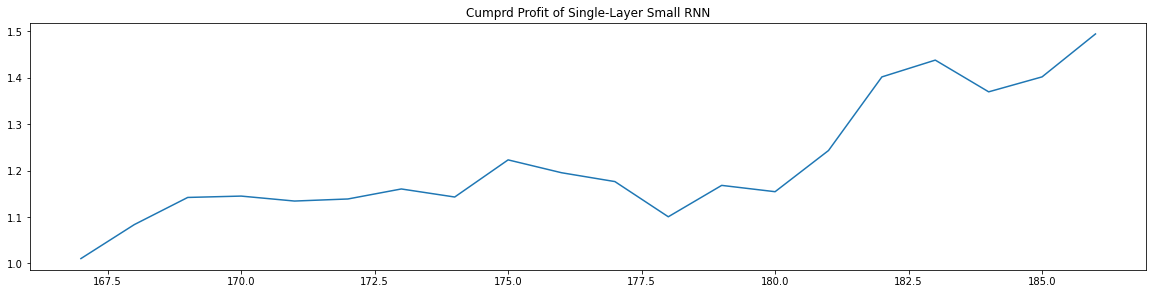

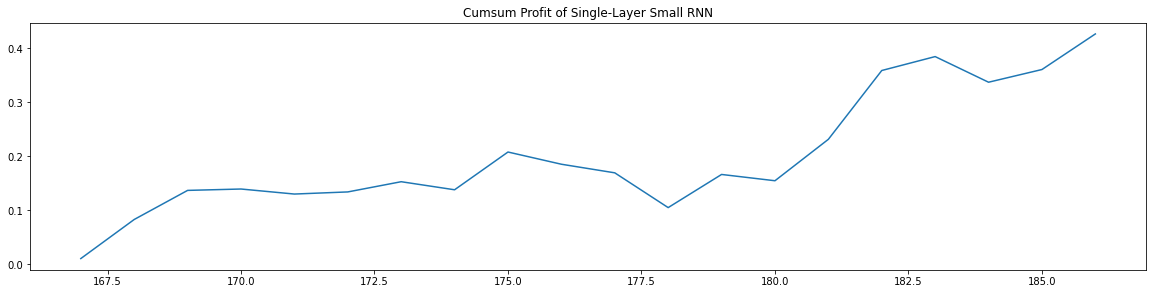

In [37]:
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=single_layer_small_rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of single layer small rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of single layer small rnn:', cumsprofit)
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Single-Layer Small RNN')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Single-Layer Small RNN')
plt.show()

cumproduct profit of single layer rnn: 167    1.010554
168    0.937363
169    0.987927
170    0.985404
171    0.994594
172    0.998505
173    1.017410
174    1.002207
175    1.072336
176    1.096596
177    1.114083
178    1.042294
179    1.106316
180    1.093433
181    1.009471
182    1.138223
183    1.108848
184    1.056166
185    1.031317
186    1.099342
Name: short, dtype: float64
cumsum profit of single layer rnn: 167    0.010554
168   -0.061872
169   -0.007930
170   -0.010483
171   -0.001157
172    0.002775
173    0.021708
174    0.006765
175    0.076739
176    0.099363
177    0.115310
178    0.050872
179    0.112296
180    0.100652
181    0.023864
182    0.151408
183    0.125600
184    0.078090
185    0.054563
186    0.120522
Name: short, dtype: float64


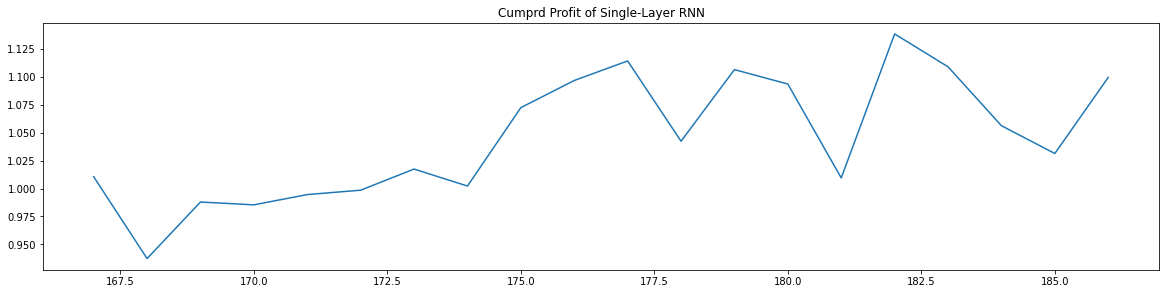

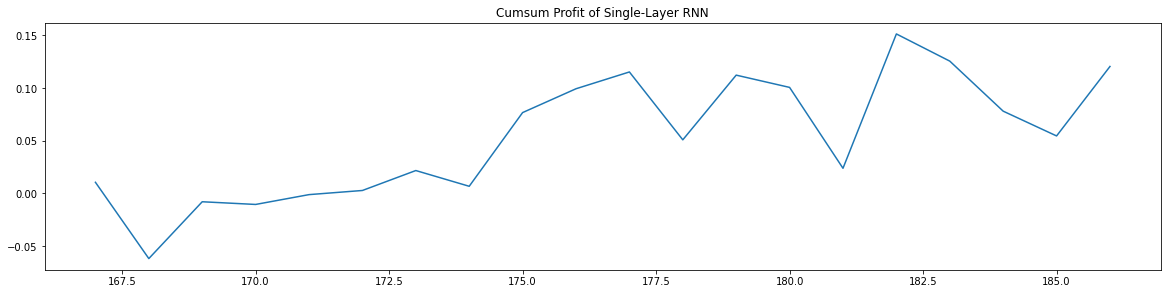

In [42]:
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=single_layer_rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of single layer rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of single layer rnn:', cumsprofit)

fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Single-Layer RNN')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Single-Layer RNN')
plt.show()

cumproduct profit of multi layer rnn: 167    1.010554
168    1.083745
169    1.142205
170    1.139288
171    1.149914
172    1.145392
173    1.167078
174    1.149638
175    1.230083
176    1.202254
177    1.183082
178    1.259318
179    1.336671
180    1.321106
181    1.219661
182    1.375222
183    1.410714
184    1.343690
185    1.312077
186    1.398620
Name: short, dtype: float64
cumsum profit of multi layer rnn: 167    0.010554
168    0.082981
169    0.136923
170    0.134369
171    0.143696
172    0.139764
173    0.158697
174    0.143754
175    0.213728
176    0.191105
177    0.175158
178    0.239596
179    0.301020
180    0.289376
181    0.212588
182    0.340132
183    0.365940
184    0.318430
185    0.294903
186    0.360862
Name: short, dtype: float64


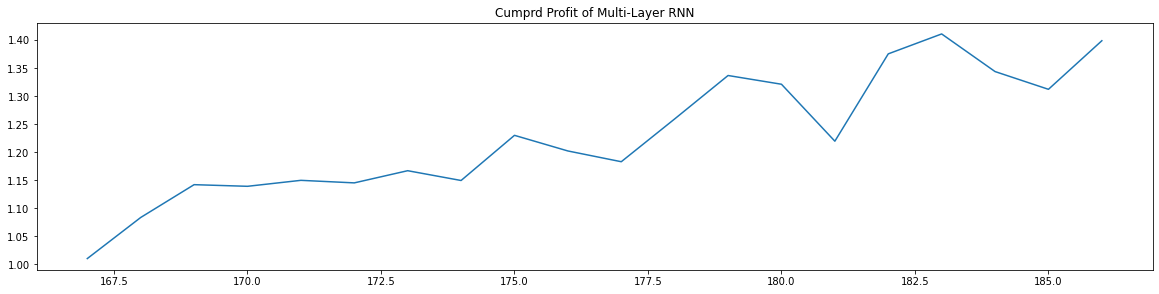

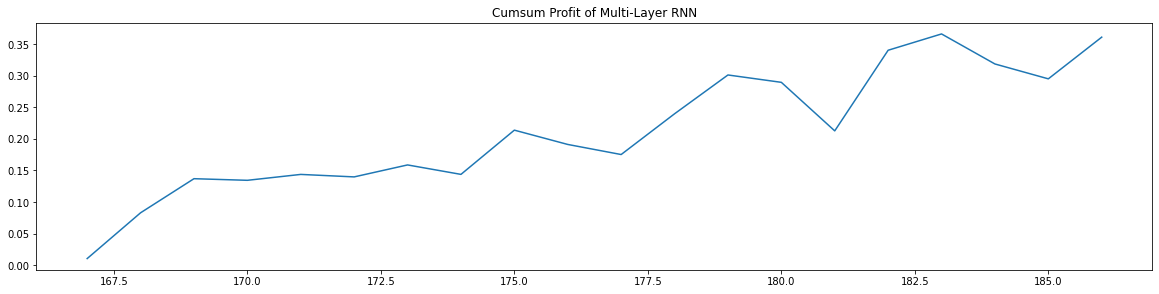

In [33]:
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of multi layer rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of multi layer rnn:', cumsprofit)

fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Multi-Layer RNN')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Multi-Layer RNN')
plt.show()

In [43]:
marketcump=(ret+1).cumprod()
marketcump

167    1.010554
168    0.937363
169    0.987927
170    0.990450
171    0.981213
172    0.985071
173    1.003721
174    0.988723
175    1.057908
176    1.033974
177    1.017486
178    0.951921
179    1.010392
180    0.998626
181    1.075308
182    1.212458
183    1.243749
184    1.184658
185    1.212530
186    1.292508
Name: return, dtype: float64

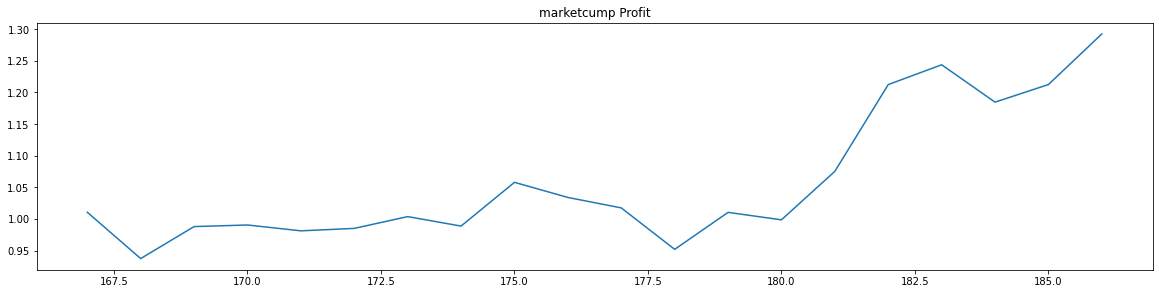

In [44]:
fig = plt.figure(figsize=(20,10))
ax3 = fig.add_subplot(2,1,1)
ax3.plot(marketcump)
ax3.set_title('marketcump Profit')
plt.show()

In [45]:
marketcums=ret.cumsum()
marketcums

167    0.010554
168   -0.061872
169   -0.007930
170   -0.005376
171   -0.014702
172   -0.010770
173    0.008163
174   -0.006780
175    0.063194
176    0.040571
177    0.024624
178   -0.039815
179    0.021610
180    0.009965
181    0.086753
182    0.214298
183    0.240106
184    0.192595
185    0.216123
186    0.282082
Name: return, dtype: float64

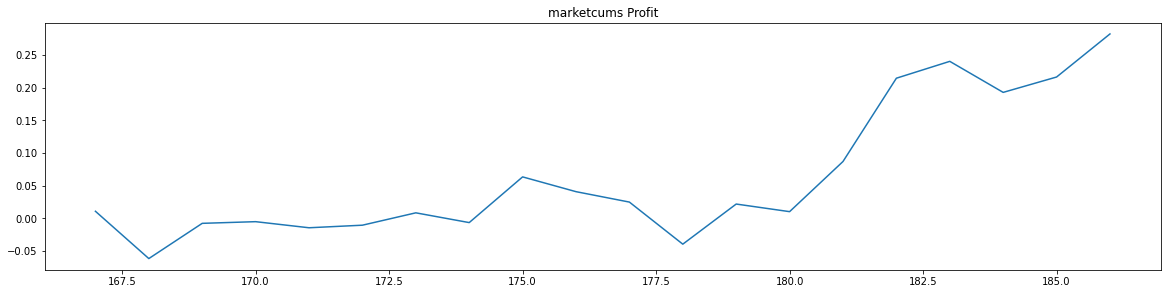

In [46]:
fig = plt.figure(figsize=(20,10))
ax2 = fig.add_subplot(2,1,1)
ax2.plot(marketcums)
ax2.set_title('marketcums Profit')
plt.show()